## 0. 환경 설정

In [151]:
import time
import random
import pandas as pd
import numpy as np
import os

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

from collections import defaultdict
import math

## 1. Layer 정의

### 1-1. 임베딩 레이어

- raw input 데이터를 저차원 임베딩 공간에 매핑하는 과정
- 예를 들어 성별이 남, 여가 있다면 이는 각각 0과 1로 매핑될 수 있고, 0에 해당되는 32차원 임베딩 공간, 1에 해당되는 임베딩 공간에 매핑하는 과정

In [152]:
class FeaturesEmbedding(Layer):  
    '''
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 됨.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성됨.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        ## int 64
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int32)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        # 임베딩을 빌드하고 초기화
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        # 들어온 입력의 임베딩을 가져옴.
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

### 1-2. DNN 레이어

- 딥러닝을 배우면 거의 가장 먼저 배울 수 있는 구조
- 비선형 레이어를 쌓아올린 구조
  - Dense layer를 쌓아올린 구조라고 생각하자.

In [153]:
# 다층 퍼셉트론
class MultiLayerPerceptron(Layer):  
    '''
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조.
    - 필요에 따라 배치 정규화도 사용할 수 있음.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]
        # Dense layer를 쌓아올립니다.
        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        # 활성화 함수를 세팅합니다.
        self.activation = tf.keras.layers.Activation(activation)
        # 필요하다면 배치정규화도 진행합니다.
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            # input data가 들어오면 layer를 돌면서 벡터 값을 가져오게 됩니다.
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            # 각 layer마다 나온 벡터 값에 활성화 함수와 dropout을 적용시켜 비선형성 구조와 과적합을 방지합니다.
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

### 1-3. 멀티 헤드 셀프 어텐션 레이어

- 쿼리(query), 키(key), 값(value)에 따른 어텐션을 계산하는 구조
- 본 모델에서는 셀프 어텐션 구조로 진행됨.

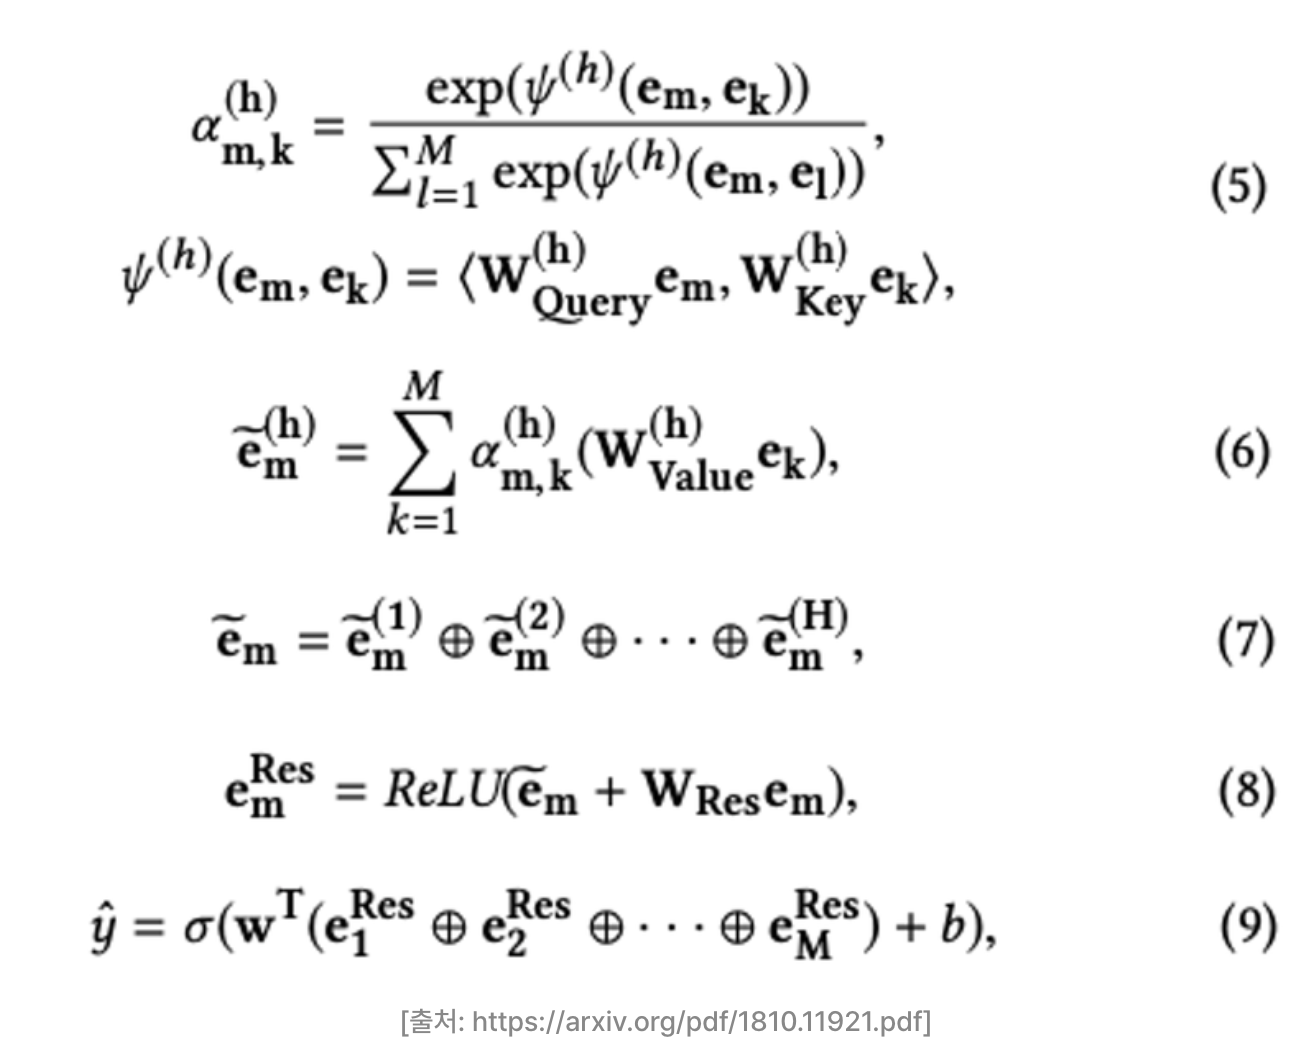

In [154]:
class MultiHeadSelfAttention(Layer):  
    '''
    멀티 헤드 셀프 어텐션 레이어입니다.
    - 위에 작성한 수식과 같이 동작됩니다.
    - 필요에 따라 잔차 연결(residual connection)도 진행합니다.
    '''
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        # 쿼리에 해당하는 매트릭스입니다. 
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        # 키에 해당되는 매트릭스입니다.
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        # 값(value)에 해당되는 매트릭스입니다.
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        # 필요하다면 잔차 연결도 할 수 있습니다.
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        
        # 입력이 들어오면 쿼리, 키, 값(value)에 매칭되어 각각의 값을 가지고 옵니다.
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        # 헤드 개수에 따라 데이터를 분리해줍니다.
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # 쿼리와 키를 먼저 곱해줍니다. 위 이미지의 식 (5)와 같습니다.
        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)
        
        # 쿼리와 키에서 나온 어텐션 값을 값(value)에 곱해줍니다. 식 (6)과 같습니다.
        result = tf.matmul(self.normalized_att_scores, values)
        # 식 (7)과 같이 쪼개어진 멀테 헤드를 모아줍니다.
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)
        
        # 그 결과 값을 리턴합니다.

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config

## 2. AutoInt 모델

In [155]:
class AutoIntMLP(Layer): 
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, dnn_hidden_units=(32, 32), dnn_activation='relu',
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoIntMLP, self).__init__()
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size

        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        
        self.dnn = tf.keras.Sequential()
        for units in dnn_hidden_units:
            self.dnn.add(Dense(units, activation=dnn_activation,
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg_dnn),
                               kernel_initializer=tf.random_normal_initializer(stddev=init_std)))
            if dnn_use_bn:
                self.dnn.add(BatchNormalization())
            self.dnn.add(Activation(dnn_activation))
            if dnn_dropout > 0:
                self.dnn.add(Dropout(dnn_dropout))
        self.dnn.add(Dense(1, kernel_initializer=tf.random_normal_initializer(stddev=init_std)))

        self.int_layers = [
    MultiHeadSelfAttention(
        att_embedding_size=embedding_size,
        head_num=att_head_num,
        use_res=att_res,
        name=f"multi_head_self_attention_{i}"
    )
    for i in range(att_layer_num)
]

    def call(self, inputs):
        embed_x = self.embedding(inputs)
        dnn_embed = tf.reshape(embed_x, shape=(-1, self.embedding_size * self.num_fields))

        att_input = embed_x
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        att_output = self.final_layer(att_output)
        
        dnn_output = self.dnn(dnn_embed)
        y_pred = tf.keras.activations.sigmoid(att_output + dnn_output)
        
        return y_pred

## 3. 평가 지표

In [156]:
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

## 4. 모델 테스트

In [157]:
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

## 5. 데이터 불러오기 및 세팅

In [158]:
project_path = os.path.abspath(os.getcwd())
data_dir_nm = 'data'
movielens_dir_nm = 'ml-1m'
model_dir_nm = 'model'
data_path = f"{project_path}/{data_dir_nm}"

In [159]:
movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [160]:
# 라벨 인코더(label encoder)
# sklearn의 LabelEncoder(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
# label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킨다.
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

In [161]:
movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,55,1,0,0,7,17,15,0,0,2,1588,1
1,0,3374,8,76,1,0,0,2,2,8,0,0,2,1588,0
2,0,3615,5,44,1,0,0,11,12,15,0,0,2,1588,0
3,0,2503,9,80,1,0,0,7,17,15,0,0,2,1588,1
4,0,1374,8,78,1,0,0,2,2,2,0,0,2,1588,1


In [162]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

In [163]:
# 3. 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [164]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int64  
 1   movie_id       800167 non-null  int64  
 2   movie_decade   800167 non-null  int64  
 3   movie_year     800167 non-null  int64  
 4   rating_year    800167 non-null  int64  
 5   rating_month   800167 non-null  int64  
 6   rating_decade  800167 non-null  int64  
 7   genre1         800167 non-null  int64  
 8   genre2         800167 non-null  int64  
 9   genre3         800167 non-null  int64  
 10  gender         800167 non-null  int64  
 11  age            800167 non-null  int64  
 12  occupation     800167 non-null  int64  
 13  zip            800167 non-null  int64  
 14  label          800167 non-null  float32
dtypes: float32(1), int64(14)
memory usage: 94.6 MB


In [165]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는 임베딩 때 활용됨.
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439])

## 6. 훈련 환경 및 모델 세팅

훈련에 앞서 환경을 정의하자.

1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

In [166]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs=5
learning_rate= 0.0001
dropout= 0.4
batch_size = 2048
embed_dim= 16

In [167]:
class AutoIntMLPModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2,
                 att_res=True, dnn_hidden_units=(32, 32), dnn_activation='relu',
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False,
                 dnn_dropout=0.4, init_std=0.0001):
        super(AutoIntMLPModel, self).__init__()
        self.autoInt_layer = AutoIntMLP(
            field_dims=field_dims,
            embedding_size=embedding_size,
            att_layer_num=att_layer_num,
            att_head_num=att_head_num,
            att_res=att_res,
            dnn_hidden_units=dnn_hidden_units,
            dnn_activation=dnn_activation,
            l2_reg_dnn=l2_reg_dnn,
            l2_reg_embedding=l2_reg_embedding,
            dnn_use_bn=dnn_use_bn,
            dnn_dropout=dnn_dropout,
            init_std=init_std
        )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

In [168]:
# 모델 정의
AutoIntMLP_Model = AutoIntMLPModel(
    field_dims=field_dims,
    embedding_size=embed_dim,
    att_layer_num=3,
    att_head_num=2,
    att_res=True,
    dnn_hidden_units=(32, 32),   # DNN 은닉층 구조
    dnn_activation='relu',       # 활성화 함수
    l2_reg_dnn=0,
    l2_reg_embedding=1e-5,
    dnn_use_bn=False,
    dnn_dropout=dropout,
    init_std=0.0001
)

In [169]:
# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

In [170]:
autoIntMLP_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_crossentropy'])

In [171]:
history = autoIntMLP_model.fit(train_df[u_i_feature + meta_features], train_df[label], epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
352/352 [==============================] - 18s 50ms/step - loss: 0.5172 - binary_crossentropy: 0.5172 - val_loss: 0.5294 - val_binary_crossentropy: 0.5294
Epoch 2/5
352/352 [==============================] - 17s 49ms/step - loss: 0.5161 - binary_crossentropy: 0.5161 - val_loss: 0.5287 - val_binary_crossentropy: 0.5287
Epoch 3/5
352/352 [==============================] - 18s 51ms/step - loss: 0.5155 - binary_crossentropy: 0.5155 - val_loss: 0.5286 - val_binary_crossentropy: 0.5286
Epoch 4/5
352/352 [==============================] - 18s 52ms/step - loss: 0.5150 - binary_crossentropy: 0.5150 - val_loss: 0.5287 - val_binary_crossentropy: 0.5287
Epoch 5/5
352/352 [==============================] - 18s 52ms/step - loss: 0.5143 - binary_crossentropy: 0.5143 - val_loss: 0.5285 - val_binary_crossentropy: 0.5285


In [172]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}

# top 10개
top = 10

# 테스트 값을 가져 오기
mymodel_user_pred_info = test_model(autoIntMLP_model, test_df)

# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져오기
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
    
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져오기
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_15046/2567990266.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
100%|███████████████████████████████████| 6038/6038 [00:00<00:00, 131315.31it/s]


In [173]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교함.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|████████████████████████████████████| 5994/5994 [00:00<00:00, 87962.22it/s]


In [174]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.6637
 mymodel hitrate :  0.63166


## 7. 모델 저장

In [175]:
# 모델 정의
AutoIntMLP_Model = AutoIntMLPModel(
    field_dims=field_dims,
    embedding_size=embed_dim,
    att_layer_num=3,
    att_head_num=2,
    att_res=True,
    dnn_hidden_units=(32, 32),   # DNN 은닉층 구조
    dnn_activation='relu',       # 활성화 함수
    l2_reg_dnn=0,
    l2_reg_embedding=1e-5,
    dnn_use_bn=False,
    dnn_dropout=dropout,
    init_std=0.0001
)

In [176]:
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439])

In [177]:
dummy_input = tf.zeros((1, len(field_dims)), dtype=tf.int32)  # ex) (1, 3)
_ = AutoIntMLP_Model(dummy_input)

In [178]:
# 저장할 경로 설정
save_path = f"{data_path}/field_dims.npy"

# 저장
np.save(save_path, field_dims)

In [179]:
# 모델의 가중치(weight) 저장
# 최근 Keras 버전(특히 TensorFlow 2.15+ 또는 Keras 3+)에서는 확장자 .weights.h5 필수
autoIntMLP_model.save_weights(f"{model_path}/autoIntMLP_model_weights.weights.h5")

/Users/choieunseo/miniconda3/envs/recsys/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [180]:
import joblib

# 모델 객체를 pickled binary file 형태로 저장
joblib.dump(label_encoders, f"{data_path}/label_encoders.pkl")

['/Users/choieunseo/Aiffel/Recommend_System/data/label_encoders.pkl']

## 8. 모델 성능 향상 시도

에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기를 조절하는 등의 다양한 시도를 하여 Autoint+ 모델의 성능을 향상시켜보자.

|| embed\_dim | dropout | lr   | batch | epochs | NDCG@10   | HitRate@10 |
| ---------- | ---------- | ------- | ---- | ----- | ------ | ------ | ------- |
| 1          | 8          | 0.2     | 1e-4 | 1024  | 3      | 0.66108 | 0.62841  |
| 2          | 16         | 0.4     | 1e-4 | 2048  | 3      | 0.66167 | 0.62972  |
| 3          | 16         | 0.2     | 1e-4 | 1024  | 3      | 0.66174 | 0.62976 |


- 임베딩 크기 증가(8 → 16) 는 NDCG와 HitRate 모두 소폭 향상시켰다.
    - 보다 정교한 사용자-아이템 표현이 성능 개선에 기여한 것으로 해석할 수 있다.

- 드롭아웃은 낮을수록(HitRate 0.62976 vs 0.62972) 미세하게 더 높은 성능을 보였으나,
차이는 거의 없으며 0.2 ~ 0.4 범위 모두 안정적인 결과를 보임.

- 학습률, 배치사이즈, 에포크가 동일한 조건에서 (16, 0.2) 조합이 **최고 성능(NDCG 0.66174 / HitRate 0.62976)**을 기록함.

> 임베딩 차원을 증가시켜 보다 풍부한 표현력을 확보하는 것이 성능 향상에 효과적이며, 드롭아웃은 0.2~0.4 수준에서 큰 차이 없이 안정적인 성능을 보였다.

In [183]:
from autointmlp import AutoIntMLPModel
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import numpy as np

# 하이퍼파라미터 실험 조합
param_grid = [
    {"embed_dim": 8,  "dropout": 0.2, "lr": 1e-4, "batch": 1024, "epochs": 3},
    {"embed_dim": 16, "dropout": 0.4, "lr": 1e-4, "batch": 2048, "epochs": 3},
    {"embed_dim": 16, "dropout": 0.2, "lr": 1e-4, "batch": 1024, "epochs": 3}
]

# 성능 저장 리스트
result_summary = []

# 실험 루프
for i, params in enumerate(param_grid):
    print(f"\n✅ 실험 {i+1} 시작 - {params}\n")

    model = AutoIntMLPModel(
        field_dims=field_dims,
        embedding_size=params["embed_dim"],
        att_layer_num=3,
        att_head_num=2,
        att_res=True,
        dnn_hidden_units=(64, 32),
        dnn_activation='relu',
        l2_reg_dnn=1e-6,
        l2_reg_embedding=1e-5,
        dnn_use_bn=False,
        dnn_dropout=params["dropout"],
        init_std=0.001
    )

    model.compile(
        optimizer=Adam(learning_rate=params["lr"]),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        train_df[u_i_feature + meta_features],
        train_df[label],
        epochs=params["epochs"],
        batch_size=params["batch"],
        validation_split=0.1,
        verbose=1
    )

    # === 예측 및 평가 ===
    user_pred_info = {}
    top = 10

    mymodel_user_pred_info = test_model(model, test_df)

    for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
        ranklist = sorted(data_info, key=lambda s: s[1], reverse=True)[:top]
        ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
        user_pred_info[str(user)] = ranklist

    test_data = test_df[test_df['label'] == 1].groupby('user_id')['movie_id'].apply(list)
    mymodel_ndcg_result = {}
    mymodel_hitrate_result = {}

    for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
        mymodel_pred = user_pred_info.get(str(user))
        if not mymodel_pred: continue
        testset = list(set(np.array(data_info).astype(int)))
        mymodel_ndcg_result[user] = get_NDCG(mymodel_pred[:top], testset)
        mymodel_hitrate_result[user] = get_hit_rate(mymodel_pred[:top], testset)

    ndcg_avg = round(np.mean(list(mymodel_ndcg_result.values())), 5)
    hitrate_avg = round(np.mean(list(mymodel_hitrate_result.values())), 5)

    print(f"✅ 실험 {i+1} 결과 → NDCG: {ndcg_avg}, Hitrate: {hitrate_avg}")

    result_summary.append({
        "experiment": i + 1,
        "params": params,
        "ndcg": ndcg_avg,
        "hitrate": hitrate_avg
    })



✅ 실험 1 시작 - {'embed_dim': 8, 'dropout': 0.2, 'lr': 0.0001, 'batch': 1024, 'epochs': 3}

Epoch 1/3
704/704 [==============================] - 14s 17ms/step - loss: 0.6644 - accuracy: 0.5761 - val_loss: 0.6101 - val_accuracy: 0.6229
Epoch 2/3
704/704 [==============================] - 12s 17ms/step - loss: 0.5950 - accuracy: 0.6925 - val_loss: 0.5864 - val_accuracy: 0.7188
Epoch 3/3
704/704 [==============================] - 12s 17ms/step - loss: 0.5807 - accuracy: 0.7234 - val_loss: 0.5791 - val_accuracy: 0.7253


/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_15046/2567990266.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
100%|████████████████████████████████████| 5994/5994 [00:00<00:00, 14988.08it/s]


✅ 실험 1 결과 → NDCG: 0.66108, Hitrate: 0.62841

✅ 실험 2 시작 - {'embed_dim': 16, 'dropout': 0.4, 'lr': 0.0001, 'batch': 2048, 'epochs': 3}

Epoch 1/3
352/352 [==============================] - 20s 54ms/step - loss: 0.6738 - accuracy: 0.5742 - val_loss: 0.6290 - val_accuracy: 0.5789
Epoch 2/3
352/352 [==============================] - 19s 55ms/step - loss: 0.5994 - accuracy: 0.6752 - val_loss: 0.5760 - val_accuracy: 0.7216
Epoch 3/3
352/352 [==============================] - 19s 55ms/step - loss: 0.5577 - accuracy: 0.7234 - val_loss: 0.5477 - val_accuracy: 0.7281


/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_15046/2567990266.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
100%|████████████████████████████████████| 5994/5994 [00:00<00:00, 14896.25it/s]


✅ 실험 2 결과 → NDCG: 0.66167, Hitrate: 0.62972

✅ 실험 3 시작 - {'embed_dim': 16, 'dropout': 0.2, 'lr': 0.0001, 'batch': 1024, 'epochs': 3}

Epoch 1/3
704/704 [==============================] - 21s 28ms/step - loss: 0.6430 - accuracy: 0.6173 - val_loss: 0.5862 - val_accuracy: 0.7175
Epoch 2/3
704/704 [==============================] - 19s 27ms/step - loss: 0.5565 - accuracy: 0.7229 - val_loss: 0.5438 - val_accuracy: 0.7285
Epoch 3/3
704/704 [==============================] - 19s 28ms/step - loss: 0.5379 - accuracy: 0.7303 - val_loss: 0.5398 - val_accuracy: 0.7306


/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_15046/2567990266.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
100%|████████████████████████████████████| 5994/5994 [00:00<00:00, 15131.40it/s]

✅ 실험 3 결과 → NDCG: 0.66174, Hitrate: 0.62976
